In [ ]:
!pip install boto3
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 10.8 MB/s eta 0:00:00


In [ ]:
import os

os.environ['AWS_ACCESS_KEY_ID'] = <access_key>
os.environ['AWS_SECRET_ACCESS_KEY'] = <secret_access_key>

In [ ]:
import boto3
import io
import json
from botocore.exceptions import ClientError, NoCredentialsError
import copy
import os
import traceback
from traceback import format_exc
import pandas as pd
import numpy as np


BUCKET = 'shares-time-series'

access_key = os.getenv('AWS_ACCESS_KEY_ID')
secret_key = os.getenv('AWS_SECRET_ACCESS_KEY')
endpoint_url = 'https://storage.yandexcloud.net'

# Создание клиента S3
s3_client = boto3.client('s3',
                         region_name='ru-central1',
                         aws_access_key_id=access_key,
                         aws_secret_access_key=secret_key,
                         endpoint_url=endpoint_url)

def upload_object_to_s3(key, body):
    response = s3_client.put_object(Bucket=BUCKET, Key=key, Body=body)
    if response['ResponseMetadata']['HTTPStatusCode'] == 200:
        print(f"Успешно сохранен в {BUCKET}/{key}")
    else:
        print(f"Ошибка при сохранении: {response['ResponseMetadata']['HTTPStatusCode']}")

def upload_data_frame_to_s3(secid, data_frame, dir=''):
    pickle_buffer = io.BytesIO()
    data_frame.to_pickle(pickle_buffer)
    pickle_buffer.seek(0)
    data_frame_file = f'{secid}/{dir}{secid}_data_frame.pkl'
    upload_object_to_s3(data_frame_file, pickle_buffer)

def upload_info_to_s3(secid, info, dir=''):
    info['miss_index'] = info['miss_index'].to_numpy().tolist()
    json_data = json.dumps(info)
    info_file = f'{secid}/{dir}{secid}_info.pkl'
    upload_object_to_s3(info_file, json_data)

def upload_data_to_s3(dict_data, dir=''):
    for secid, data in dict_data.items():
        try:
            copy_data = copy.deepcopy(data)
            upload_data_frame_to_s3(secid, copy_data['data_frame'], dir)
            del copy_data['data_frame']
            upload_info_to_s3(secid, copy_data, dir)
        except ClientError as e:
            print(f"Произошла ошибка: {e.response['Error']['Message']}")
        except Exception as e:
            error_message = f"Неизвестная ошибка: {str(e)}"
            error_context = traceback.format_exc()
            print(f"{error_message}\nКонтекст ошибки:\n{error_context}")

def list_directories(s3_client):
    directories = set()
    try:
        paginator = s3_client.get_paginator('list_objects_v2')
        for page in paginator.paginate(Bucket=BUCKET, Delimiter='/'):
            for prefix in page.get('CommonPrefixes', []):
                directories.add(prefix.get('Prefix'))
    except NoCredentialsError:
        print("Ошибка: Неверные учетные данные.")
    except Exception as e:
        print(f"Произошла ошибка: {e}")
    return directories

def download_object_from_s3(key):
    response = s3_client.get_object(Bucket=BUCKET, Key=key)
    if response['ResponseMetadata']['HTTPStatusCode'] == 200:
        print(f"Успешно получен из {BUCKET}/{key}")
    else:
        print(f"Ошибка при получении: {response['ResponseMetadata']['HTTPStatusCode']}")
    return response['Body'].read()

def download_info_from_s3(secid, dir=''):
    key = f'{secid}/{dir}{secid}_info.pkl'
    response = download_object_from_s3(key)
    data = json.loads(response)
    data['miss_index'] = pd.Index(np.array(data['miss_index']))
    return data

def download_data_frame_from_s3(secid, dir=''):
    key = f'{secid}/{dir}{secid}_data_frame.pkl'
    response = download_object_from_s3(key)
    buffer = io.BytesIO(response)
    data = pd.read_pickle(buffer)
    data['TRADEDATE'] = pd.to_datetime(data['TRADEDATE'])
    return data

def download_data_from_s3(secids=None, dir=''):
    directories = [dir[:-1] for dir in list_directories(s3_client)]
    data = {}
    for secid in directories:
        if secids is None or secid in secids:
            try:
                if secids is not None:
                    secids.remove(secid)
                data[secid] = download_info_from_s3(secid, dir)
                data[secid]['data_frame'] = download_data_frame_from_s3(secid, dir)
            except Exception as e:
                print(f"Произошла ошибка: {e}")
    if secids is not None and len(secids) > 0:
        print(f'Не нашли {secids}')
    return data

In [ ]:
df = download_data_from_s3(secids=['SBER', 'YDEX'], dir='normal_start/')

Успешно получен из shares-time-series/SBER/normal_start/SBER_info.pkl
Успешно получен из shares-time-series/SBER/normal_start/SBER_data_frame.pkl
Успешно получен из shares-time-series/YDEX/normal_start/YDEX_info.pkl
Успешно получен из shares-time-series/YDEX/normal_start/YDEX_data_frame.pkl


In [ ]:
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
%matplotlib inline
from sktime.utils.plotting import plot_series

<ipython-input-9-67f2c26be003>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Преобразуем в данные для отображения

In [ ]:
data = df['YDEX']['data_frame'][['TRADEDATE', 'CLOSE']].set_index('TRADEDATE')

Отображаем график

<Figure size 1500x600 with 0 Axes>

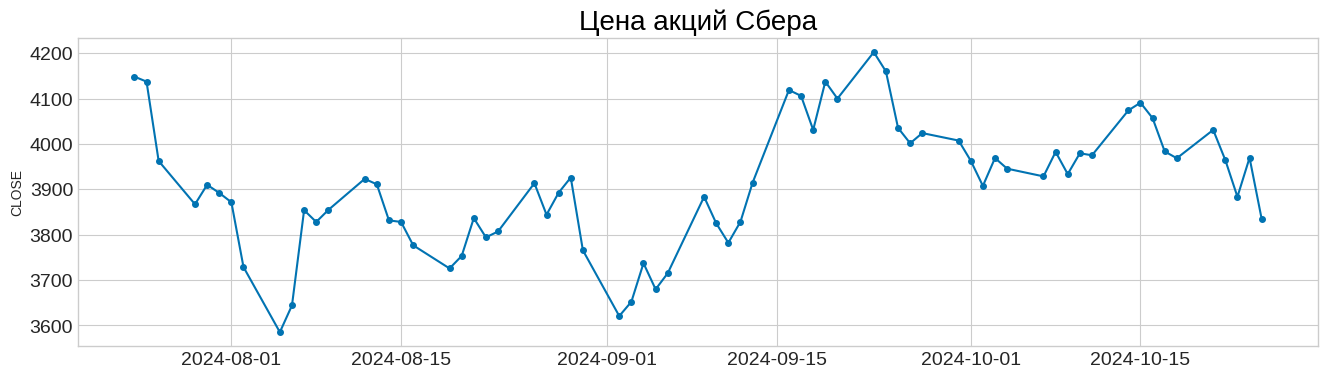

In [ ]:
plt.figure(figsize=(15,6))
y = data['CLOSE']
plot_series(y)
plt.title('Цена акций Сбера', fontsize=20, color='black')
plt.tick_params(axis='both', which='major', labelsize=14)

Функция для вычисления ошибки

In [ ]:
def mape(y_true, y_pred):
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Разбиваем на обучение и тест

55 13


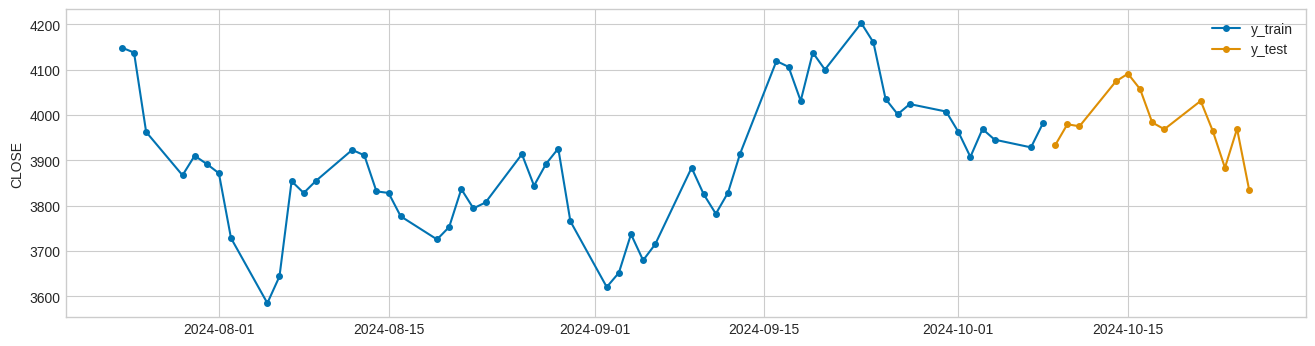

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split

# один год ~365 в месяце около 20 дней рабочих, поэтому
days = int(20 / 30 * 20.5)
y_train, y_test = temporal_train_test_split(y, test_size=days)
plot_series(y_train, y_test, labels=['y_train', 'y_test'])
print(y_train.shape[0], y_test.shape[0])

Формируем даты тестов для нормального отображения в будущем

In [ ]:
from sktime.forecasting.base import ForecastingHorizon
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2024-10-09', '2024-10-10', '2024-10-11', '2024-10-14',
               '2024-10-15', '2024-10-16', '2024-10-17', '2024-10-18',
               '2024-10-21', '2024-10-22', '2024-10-23', '2024-10-24',
               '2024-10-25'],
              dtype='datetime64[ns]', freq=None, is_relative=False)

Наивный прогноз

In [ ]:
y_train.index[0], y_train.index[-1]

(Timestamp('2013-03-25 00:00:00'), Timestamp('2023-11-03 00:00:00'))

In [ ]:
y_train.index = pd.date_range(start=y_train.index[0], end=y_train.index[-1], freq='B')

ValueError: Length mismatch: Expected axis has 2678 elements, new values have 2770 elements

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='CLOSE'>)

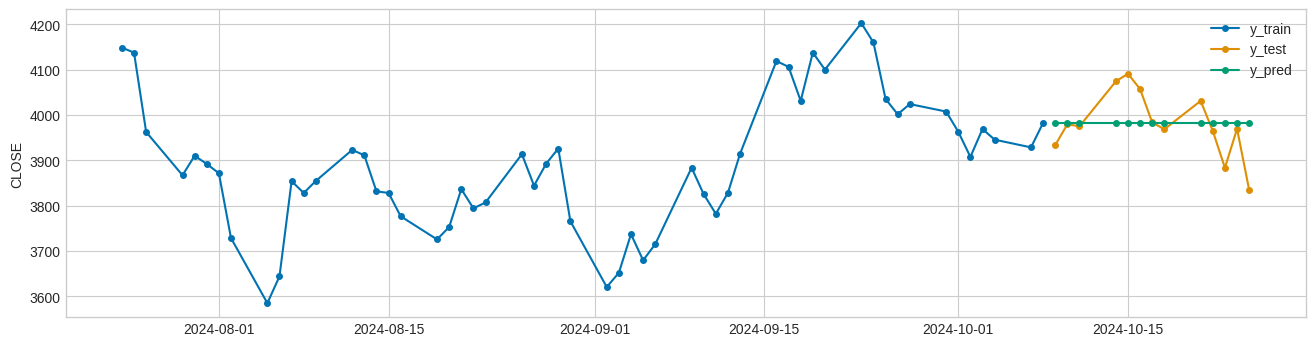

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy='last')
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])

In [ ]:
mape(y_pred, y_test)

1.304746728475542

/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='CLOSE'>)

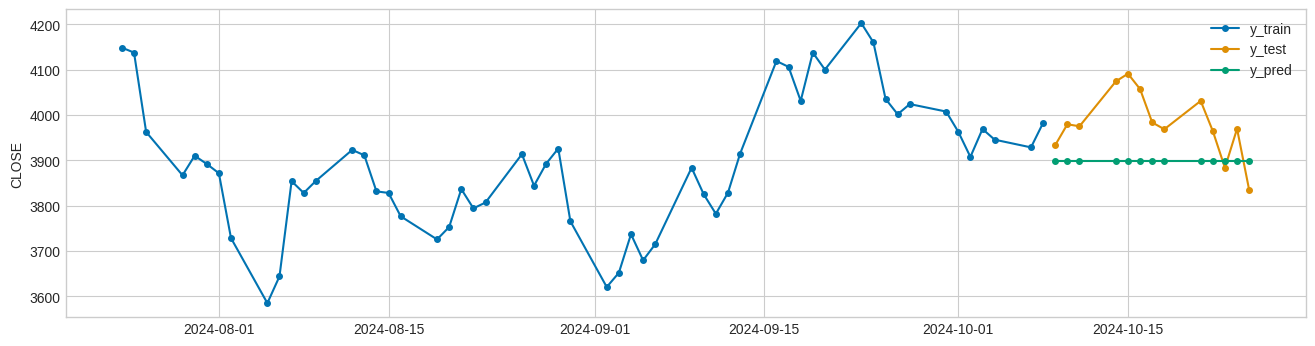

In [ ]:
forecaster = NaiveForecaster(strategy='mean', window_length=40)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])

In [ ]:
mape(y_pred, y_test)

2.406887348359538

/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)


4.194596221340303

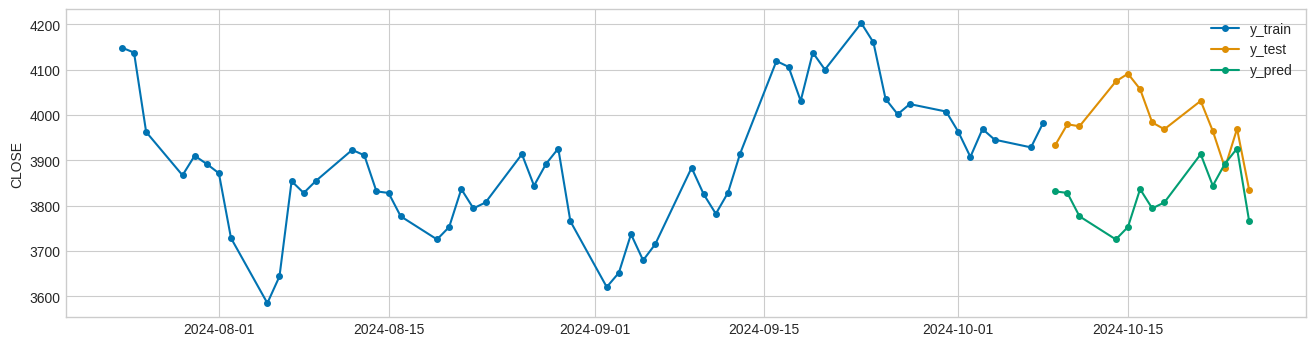

In [ ]:
forecaster = NaiveForecaster(strategy='mean', sp=40)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
mape(y_pred, y_test)

/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)


1.3414689370318895

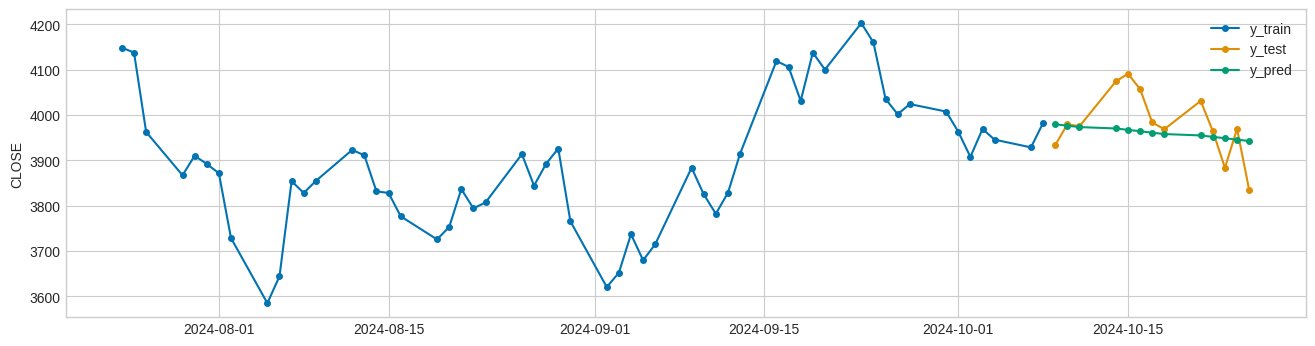

In [ ]:
forecaster = NaiveForecaster(strategy='drift')
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
mape(y_pred, y_test)

In [ ]:
forecaster = NaiveForecaster(strategy='last', sp=days)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
mape(y_pred, y_test)

/usr/local/lib/python3.10/dist-packages/sktime/utils/seasonality.py:174: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  df.index = df.index.to_period(freq=freq)
/usr/local/lib/python3.10/dist-packages/sktime/utils/seasonality.py:119: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  aix = anchor.index.to_period(freq=freq)
/usr/local/lib/python3.10/dist-packages/sktime/utils/seasonality.py:162: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  df_pivot.index = df_pivot.index.to_timestamp(


NullFrequencyError: Cannot shift with no freq

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  return x.to_period(freq)
/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: Period w

1.3032728882689792

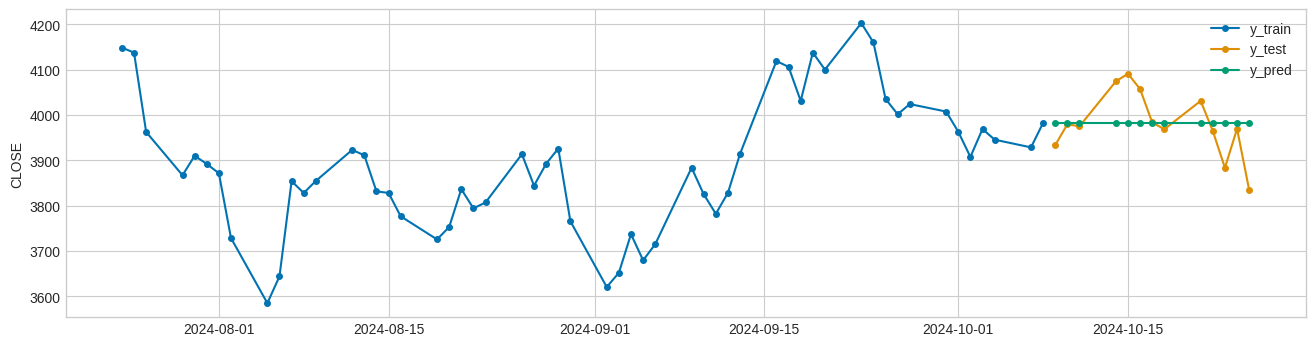

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ExponentialSmoothing()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
mape(y_pred, y_test)

In [ ]:
forecaster.get_fitted_params()

{'initial_level': 4194.066666666664,
 'initial_slope': None,
 'initial_seasons': array([], dtype=float64),
 'aic': 491.1270265247914,
 'bic': 495.14169289525637,
 'aicc': 491.9270265247914}

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  return x.to_period(freq)
/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: Period w

1.3578085214898046

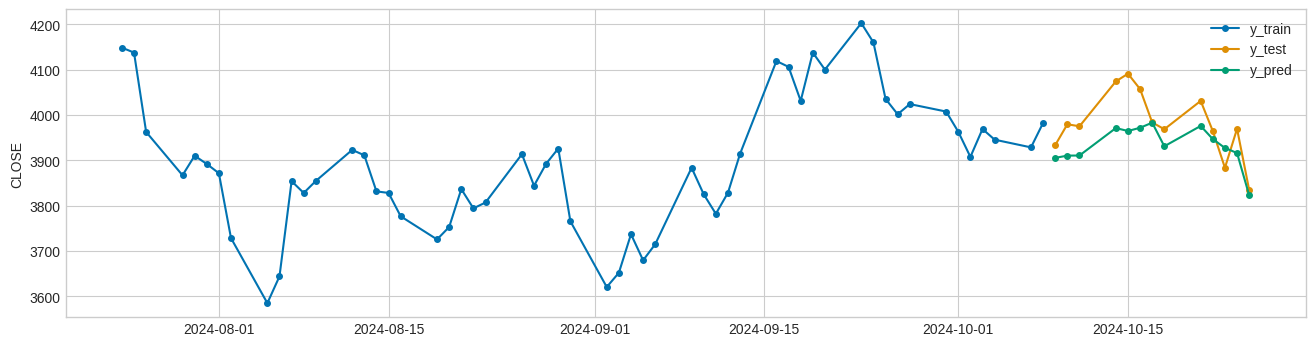

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ExponentialSmoothing(trend='add', seasonal='add', sp=20)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
mape(y_pred, y_test)

In [ ]:
forecaster.get_fitted_params()

{'initial_level': 4106.154815613804,
 'initial_slope': None,
 'initial_seasons': array([  72.64231422,   88.06283025,   40.36301215,   89.45846746,
          64.61854442,   49.44268063,   42.42745137,  -46.52076038,
        -137.06308513, -120.88039997,  -32.78556565,  -33.53898839,
         -18.25553482,   59.37549754,   53.36107901,  -15.05426177,
          -5.94280174,   -1.33942187,   63.40515692,   61.22489797]),
 'aic': 514.8756606285472,
 'bic': 563.0516570741264,
 'aicc': 565.0185177714043}

/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/_fh.py:941: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  return x.to_period(freq)


1.3047172077699791

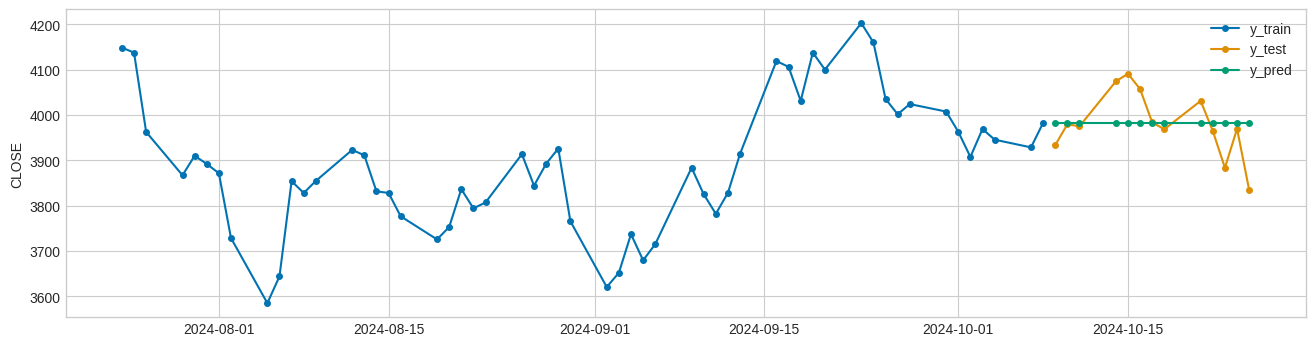

In [ ]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True, n_jobs=-1, information_criterion='bic')
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
mape(y_pred, y_test)

In [ ]:
import statsmodels.api as sm
ets_aaa = sm.tsa.statespace.ExponentialSmoothing(y_train, trend=True, seasonal=24)
ets_aaa_res = ets_aaa.fit()
print(ets_aaa_res.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


NullFrequencyError: Cannot shift with no freq

In [ ]:
h = days
df_forecast = ets_aaa_res.get_forecast(h).summary_frame()
df_forecast.index = df
df_forecast.head()

NameError: name 'ets_aaa_res' is not defined

In [ ]:
dig, ax = plot_series(y_train, y_test, df_forecast['mean'], labels=['y_train', 'y_test'])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    df_forecast['mean_ci_lower'],
    df_forecast['mean_ci_upper'],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f'95% prediction intervals'
)
ax.legend(loc='lower left')

In [ ]:
mape(y_test, df_forecast['mean'])

In [ ]:
ets_aaa_res.plot_diagnostics(figsize=(10, 8));